In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import *

np.random.seed(0)

In [2]:
Z_holdout = pd.read_csv("data/Z_holdout.csv", index_col="DATE")
Z = pd.read_csv("data/Z.csv", index_col="DATE")

Z_holdout.index = pd.to_datetime(Z_holdout.index)
Z.index = pd.to_datetime(Z.index)

df_holdout = pd.read_csv("data/df_holdout.csv", index_col="date")
df = pd.read_csv("data/df.csv", index_col="DATE")

df_holdout.index = pd.to_datetime(df_holdout.index)
df.index = pd.to_datetime(df.index)

num_quantiles = 10
num_assets = len(df.columns)

start_train = df.index[0].strftime("%Y-%m-%d")
backtest_date = df_holdout.index[0].strftime("%Y-%m-%d")

In [3]:
#load files
means_file = open('models/stratified_return.pkl', 'rb')
means = pickle.load(means_file)
means_file.close()

common_means_file = open('models/common_return.pkl', 'rb')
common_means = pickle.load(common_means_file)
common_means_file.close()

covs_file = open('models/stratified_risk.pkl', 'rb')
covs = pickle.load(covs_file)
covs_file.close()

theta_common_file = open('models/common_risk.pkl', 'rb')
theta_common = pickle.load(theta_common_file)
theta_common_file.close()

common_covs = {}
for node in common_means.keys():
    common_covs[node] = theta_common.copy()

In [4]:
#bid-ask spreads
ba = pd.read_csv("data/bid_asks.csv")
ba["spread"] = ba["ASK"] - ba["BID"]
ba["spread_bps"] = ba["spread"]/ba["PRC"]
ba = ba[["date", "TICKER", "spread_bps"]]
ba["date"] = pd.to_datetime(ba["date"])
ba_all = pd.pivot_table(ba, index="date", values="spread_bps", columns="TICKER")
ba_all = ba_all.fillna(ba_all.loc[start_train:].mean()).abs()
ba_all = ba_all.replace(to_replace=0, method='ffill')

kappa = np.full(num_assets,0.0005)

In [5]:
VALS_common, _, Wcommon, sharpes_common, _ = backtest(returns=df_holdout.values,
                                                        Z_returns=Z_holdout,
                                                        benchmark=df_holdout["VTI"],
                                                        means=common_means, covs=common_covs,
                                                        lev_lim=2,
                                                        bottom_sec_limit=-0.25, 
                                                        upper_sec_limit=0.4,
                                                        shorting_cost=1,
                                                        tcost=0.383,
                                                        MAXRISK=2e-5,
                                                        kappa=kappa,
                                                        bid_ask = ba_all)

print("COMMON MODEL: Sharpe =", sharpes_common["policy"])

COMMON MODEL: Sharpe = 0.038013083236383347


In [6]:
VALS, df_Zs, W, sharpes_test, _ = backtest(returns=df_holdout.values,
                                                        Z_returns=Z_holdout,
                                                        benchmark=df_holdout["VTI"],
                                                        means=means, covs=covs,
                                                        lev_lim=2,
                                                        bottom_sec_limit=-0.25, 
                                                        upper_sec_limit=0.4,
                                                        shorting_cost=8.25,
                                                        tcost=1.47,
                                                        MAXRISK=2e-5,
                                                        kappa=kappa,
                                                        bid_ask = ba_all)

print("LRSM: Sharpe =",sharpes_test["policy"])
VALS["Common model policy"] = VALS_common["policy"]
VALS.rename(columns={"policy":"Stratified model policy"}, inplace=True)

LRSM: Sharpe = 0.302048330162529


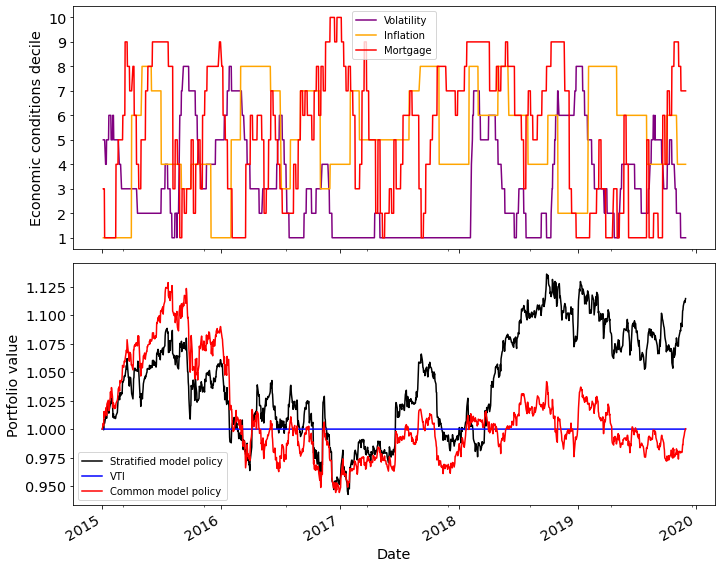

In [7]:
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)

mapping = {"vix":"Volatility", "inflation":"Inflation", "mort30us":"Mortgage"}
df_Zs = df_Zs.rename(columns=mapping)

(1+df_Zs).plot(ax=ax[0], color=["purple", "orange", "red"], fontsize="x-large",
              yticks=range(1,11))

VALS = VALS.rename(columns={"benchmark":"VTI"})
VALS.plot(ax=ax[1], color=["black", "blue", "red"], fontsize="x-large")
ax[0].set_xlabel("Date", fontsize="x-large")
ax[0].set_ylabel("Economic conditions decile", fontsize="x-large")
ax[1].set_xlabel("Date", fontsize="x-large")
ax[1].set_ylabel("Portfolio value", fontsize="x-large")


plt.tight_layout()
plt.show()

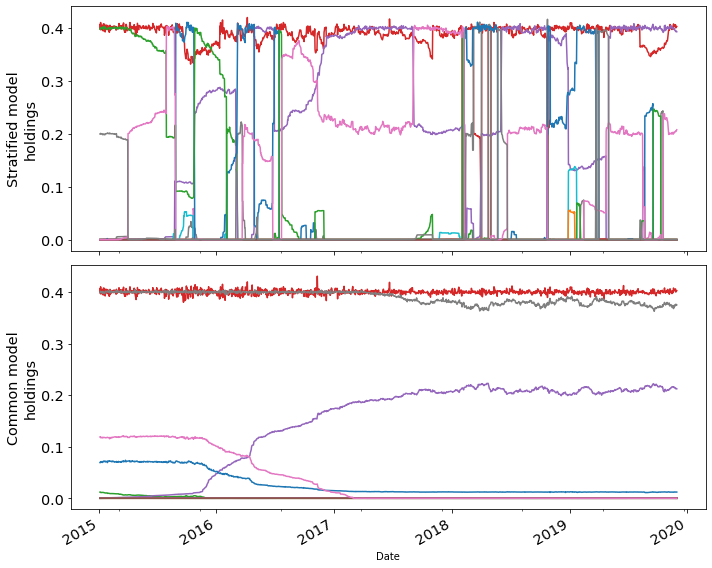

In [8]:
fig, ax = plt.subplots(2,1,figsize=(10,8), sharex=True)

W[0] = W[0].reshape(-1,1)
Wcommon[0] = Wcommon[0].reshape(-1,1)

holds_sm = pd.DataFrame(np.hstack(W).T[1:,:], index=VALS.index[1:], columns=df.columns)
holds_cm = pd.DataFrame(np.hstack(Wcommon).T[1:,:], index=VALS.index[1:], columns=df.columns)
holds_sm.plot(ax=ax[0], fontsize="x-large", legend=False)
holds_cm.plot(ax=ax[1], fontsize="x-large", legend=False)

ax[0].set_ylabel("Stratified model\nholdings", fontsize="x-large")
ax[1].set_ylabel("Common model\nholdings", fontsize="x-large")

plt.tight_layout()
plt.show()

In [9]:
def annualized_return_risk(vals):
    
    vals = vals.pct_change()
    P = 250

    ann_return = vals.mean()*P
    ann_risk = vals.std()*np.sqrt(P)
    
    return ann_return, ann_risk

ret_sm, risk_sm = annualized_return_risk(vals=VALS["Stratified model policy"])
ret_common, risk_common = annualized_return_risk(vals=VALS["Common model policy"])

max_drawdown = 100*((VALS.cummax() - VALS)/VALS.cummax()).max()

print("\t\tANNUALIZED")
print("\t\tRETURN    RISK  SHARPE MAX DD %")
print("Stratified\nmodel:")
print("\t", ret_sm.round(4), risk_sm.round(5), (ret_sm/risk_sm).round(4), max_drawdown["Stratified model policy"].round(1))
print("Common\nmodel:")
print("\t", ret_common.round(3), risk_common.round(3), (ret_common/risk_common).round(4), max_drawdown["Common model policy"].round(1))

		ANNUALIZED
		RETURN    RISK  SHARPE MAX DD %
Stratified
model:
	 0.0255 0.08429 0.302 13.4
Common
model:
	 0.003 0.075 0.038 16.3


In [10]:
fs = ["mktrf", "smb", "hml", "umd"]
factors = pd.read_csv("data/fama_french_factors.csv", index_col="date")
factors.index = pd.to_datetime(factors.index)
factors["alpha"] = 1
Y = VALS["Stratified model policy"].pct_change().dropna()
X = factors.loc[Y.index,fs+["alpha"]]

strat_ff = np.linalg.inv(X.T@X)@X.T@Y
strat_ff = pd.DataFrame(strat_ff.values.reshape(1,-1), columns=fs+["alpha"], index=["Stratified model policy"]).T

factors = pd.read_csv("data/fama_french_factors.csv", index_col="date")
factors.index = pd.to_datetime(factors.index)
factors["alpha"] = 1
Y = VALS["Common model policy"].pct_change().dropna()
X = factors.loc[Y.index,fs+["alpha"]]

common_ff = np.linalg.inv(X.T@X)@X.T@Y
common_ff = pd.DataFrame(common_ff.values.reshape(1,-1), columns=fs+["alpha"], index=["Common model policy"]).T

ff_table = pd.concat([strat_ff, common_ff], axis=1)
ff_table

,Stratified model policy,Common model policy
mktrf,-0.001362,0.058458
smb,0.279307,0.266135
hml,-0.361305,-0.418144
umd,-0.174945,-0.101514
alpha,0.000085,-0.000055
